Import Libraries

In [1]:
import sys
import os
import shutil
import glob
import natsort
import pickle
import dlib
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [2]:
dataset_name = 'CASME_sq' #Change to either 'CASME_sq' or 'SAMMLV' only

Dlib to detect the facial region and crop to 128x128

In [4]:
predictor_model = "Utils\\shape_predictor_68_face_landmarks.dat"
face_detector = dlib.get_frontal_face_detector()
face_pose_predictor = dlib.shape_predictor(predictor_model)

print('Running...')
if(dataset_name == 'CASME_sq'):
    # Save the images into folder 'rawpic_crop'
    for subjectName in glob.glob(dataset_name + '\\rawpic\\*'):
        dataset_rawpic = dataset_name + '\\rawpic\\' + str(subjectName.split('\\')[-1]) + '\\*'

        # Create new directory for 'rawpic_crop'
        dir_crop = dataset_name + '\\rawpic_crop\\'
        if os.path.exists(dir_crop)==False:
          os.mkdir(dir_crop)

        #Create new directory for each subject
        dir_crop_sub = dataset_name + '\\rawpic_crop\\' + str(subjectName.split('\\')[-1]) + '\\'
        if os.path.exists(dir_crop_sub):
          shutil.rmtree(dir_crop_sub)
        os.mkdir(dir_crop_sub)
        print('Subject', subjectName.split('\\')[-1])
        for vid in glob.glob(dataset_rawpic):
          dir_crop_sub_vid = dir_crop_sub + vid.split('\\')[-1] #Get dir of video
          if os.path.exists(dir_crop_sub_vid): 
              shutil.rmtree(dir_crop_sub_vid)
          os.mkdir(dir_crop_sub_vid)
          for dir_crop_sub_vid_img in natsort.natsorted(glob.glob(vid+'\\img*.jpg')): #Read images
            img = dir_crop_sub_vid_img.split('\\')[-1]
            count = img[3:-4] #Get img num Ex 001,002,...,2021
            # Load the image
            image = cv2.imread(dir_crop_sub_vid_img)
            # Run the HOG face detector on the image data
            detected_faces = face_detector(image, 1)

            if (count == '001'): #Use first frame as reference frame
                for face_rect in detected_faces:
                    face_top = face_rect.top()
                    face_bottom = face_rect.bottom()
                    face_left = face_rect.left()
                    face_right = face_rect.right()

            face = image[face_top:face_bottom, face_left:face_right] #Crop the face region
            face = cv2.resize(face, (128, 128)) #Resize to 128x128

            cv2.imwrite(dir_crop_sub_vid + "\\img{}.jpg".format(count), face)

          print('Done Video', vid.split('\\')[-1])
    
elif(dataset_name == 'SAMMLV'):
    if os.path.exists(dataset_name + '\\SAMM_longvideos_crop'): #Delete dir if exist and create new dir
      shutil.rmtree(dataset_name + '\\SAMM_longvideos_crop')
    os.mkdir(dataset_name + '\\SAMM_longvideos_crop')

    for vid in glob.glob(dataset_name + '\\SAMM_longvideos\\*'):
        count = 0
        dir_crop = dataset_name + '\\SAMM_longvideos_crop\\' + vid.split('\\')[-1]

        if os.path.exists(dir_crop): #Delete dir if exist and create new dir
          shutil.rmtree(dir_crop)
        os.mkdir(dir_crop)
        print('Video', vid.split('\\')[-1])
        for dir_crop_img in natsort.natsorted(glob.glob(vid+'\\*.jpg')):
            img = dir_crop_img.split('\\')[-1].split('.')[0]
            count = img[-4:] #Get img num Ex 0001,0002,...,2021
            # Load the image
            image = cv2.imread(dir_crop_img)

            # Run the HOG face detector on the image data
            detected_faces = face_detector(image, 1)

            # Loop through each face we found in the image
            if (count == '0001'): #Use first frame as reference frame
                for i, face_rect in enumerate(detected_faces):
                    face_top = face_rect.top()
                    face_bottom = face_rect.bottom()
                    face_left = face_rect.left()
                    face_right = face_rect.right()

            face = image[face_top:face_bottom, face_left:face_right]
            face = cv2.resize(face, (128, 128)) 

            cv2.imwrite(dir_crop + "\\{}.jpg".format(count), face)

        print('Done Video', vid.split('\\')[-1])
print(dataset_name, 'All Done!!')

Running...
Subject s15
Done Video 15_0101disgustingteeth
Done Video 15_0102eatingworms
Done Video 15_0401girlcrashing
Done Video 15_0402beatingpregnantwoman
Done Video 15_0502funnyerrors
Done Video 15_0503unnyfarting
Done Video 15_0505funnyinnovations
Done Video 15_0508funnydunkey
Subject s16
Done Video 16_0101disgustingteeth
Done Video 16_0102eatingworms
Done Video 16_0401girlcrashing
Done Video 16_0402beatingpregnantwoman
Done Video 16_0502funnyerrors
Done Video 16_0505funnyinnovations
Done Video 16_0507climbingthewall
Subject s19
Done Video 19_0102eatingworms
Done Video 19_0402beatingpregnantwoman
Done Video 19_0505funnyinnovations
Done Video 19_0507climbingthewall
Subject s20
Done Video 20_0502funnyerrors
Subject s21
Done Video 21_0101disgustingteeth
Done Video 21_0401girlcrashing
Subject s22
Done Video 22_0101disgustingteeth
Done Video 22_0102eatingworms
Done Video 22_0402beatingpregnantwoman
Done Video 22_0503unnyfarting
Done Video 22_0508funnydunkey
Subject s23
Done Video 23_010

Read images from folder and store into pkl for ease of training

In [4]:
images = []
subjects = []
subjectsVideos = []

print('Running...')
if(dataset_name == 'CASME_sq'):
    for i, dir_sub in enumerate(natsort.natsorted(glob.glob(dataset_name + "\\rawpic_crop\\*"))):
      print('Subject: ' + dir_sub.split('\\')[-1])
      subjects.append(dir_sub.split('\\')[-1])
      subjectsVideos.append([])
      for dir_sub_vid in natsort.natsorted(glob.glob(dir_sub + "\\*")):
        subjectsVideos[-1].append(dir_sub_vid.split('\\')[-1].split('_')[1][:4]) # Ex:'CASME_sq/rawpic_aligned/s15/15_0101disgustingteeth' -> '0101' 
        image = []
        for dir_sub_vid_img in natsort.natsorted(glob.glob(dir_sub_vid + "\\img*.jpg")):
          image.append(cv2.imread(dir_sub_vid_img, 0))
        print('Done -> ' + dir_sub_vid.split('\\')[-1])
        images.append(np.array(image))
    
elif(dataset_name == 'SAMMLV'):
    for i, dir_vid in enumerate(natsort.natsorted(glob.glob(dataset_name + "\\SAMM_longvideos_crop\\*"))):
      subject = dir_vid.split('\\')[-1].split('_')[0]
      subjectVideo = dir_vid.split('\\')[-1]
      if (subject not in subjects): #Only append unique subject name
        subjects.append(subject)
        subjectsVideos.append([])
      subjectsVideos[-1].append(dir_vid.split('\\')[-1])

      image = []
      for dir_vid_img in natsort.natsorted(glob.glob(dir_vid + "\\*.jpg")):
        image.append(cv2.imread(dir_vid_img, 0))
      image = np.array(image)
      print('Done -> ' + dir_vid.split('\\')[-1])
      images.append(image)

print(dataset_name, 'All Done')

Running...
Subject: s15
Done -> 15_0101disgustingteeth
Done -> 15_0102eatingworms
Done -> 15_0401girlcrashing
Done -> 15_0402beatingpregnantwoman
Done -> 15_0502funnyerrors
Done -> 15_0503unnyfarting
Done -> 15_0505funnyinnovations
Done -> 15_0508funnydunkey
Subject: s16
Done -> 16_0101disgustingteeth
Done -> 16_0102eatingworms
Done -> 16_0401girlcrashing
Done -> 16_0402beatingpregnantwoman
Done -> 16_0502funnyerrors
Done -> 16_0505funnyinnovations
Done -> 16_0507climbingthewall
Subject: s19
Done -> 19_0102eatingworms
Done -> 19_0402beatingpregnantwoman
Done -> 19_0505funnyinnovations
Done -> 19_0507climbingthewall
Subject: s20
Done -> 20_0502funnyerrors
Subject: s21
Done -> 21_0101disgustingteeth
Done -> 21_0401girlcrashing
Subject: s22
Done -> 22_0101disgustingteeth
Done -> 22_0102eatingworms
Done -> 22_0402beatingpregnantwoman
Done -> 22_0503unnyfarting
Done -> 22_0508funnydunkey
Subject: s23
Done -> 23_0102eatingworms
Done -> 23_0402beatingpregnantwoman
Done -> 23_0502funnyerrors
D

In [5]:
# Store the data into pkl files for model training
pickle.dump(images, open(dataset_name + "_images_crop.pkl", "wb") )
pickle.dump(subjectsVideos, open(dataset_name + "_subjectsVideos_crop.pkl", "wb") )
pickle.dump(subjects, open(dataset_name + "_subjects_crop.pkl", "wb") )

In [6]:
# For loading the pkl files
# images = pickle.load( open( dataset_name + "_images_crop.pkl", "rb" ) )
# subjectsVideos = pickle.load( open( dataset_name + "_subjectsVideos_crop.pkl", "rb" ) )
# subjects = pickle.load( open( dataset_name + "_subjects_crop.pkl", "rb" ) )

Read data from Excel file

In [7]:
if(dataset_name == 'CASME_sq'):
    xl = pd.ExcelFile(dataset_name + '/code_final.xlsx') #Specify directory of excel file

    colsName = ['subject', 'video', 'onset', 'apex', 'offset', 'au', 'emotion', 'type', 'selfReport']
    codeFinal = xl.parse(xl.sheet_names[0], header=None, names=colsName) #Get data

    videoNames = []
    for videoName in codeFinal.iloc[:,1]:
        videoNames.append(videoName.split('_')[0])
    codeFinal['videoName'] = videoNames

    naming1 = xl.parse(xl.sheet_names[2], header=None, converters={0: str})
    dictVideoName = dict(zip(naming1.iloc[:,1], naming1.iloc[:,0]))
    codeFinal['videoCode'] = [dictVideoName[i] for i in codeFinal['videoName']]

    naming2 = xl.parse(xl.sheet_names[1], header=None)
    dictSubject = dict(zip(naming2.iloc[:,2], naming2.iloc[:,1]))
    codeFinal['subjectCode'] = [dictSubject[i] for i in codeFinal['subject']]
    
elif(dataset_name=='SAMMLV'):
    xl = pd.ExcelFile(dataset_name + '/SAMM_LongVideos_V2_Release.xlsx')

    colsName = ['Subject', 'Filename', 'Inducement Code', 'Onset', 'Apex', 'Offset', 'Duration', 'Type', 'Action Units', 'Notes']
    codeFinal = xl.parse(xl.sheet_names[0], header=None, names=colsName, skiprows=[0,1,2,3,4,5,6,7,8,9])

    videoNames = []
    subjectName = []
    for videoName in codeFinal.iloc[:,1]:
        videoNames.append(str(videoName).split('_')[0] + '_' + str(videoName).split('_')[1])
        subjectName.append(str(videoName).split('_')[0])
    codeFinal['videoCode'] = videoNames
    codeFinal['subjectCode'] = subjectName
    #Synchronize the columns name with CAS(ME)^2
    codeFinal.rename(columns={'Type':'type', 'Onset':'onset', 'Offset':'offset', 'Apex':'apex'}, inplace=True) 
    
print('Data Columns:', codeFinal.columns) #Final data column

Data Columns: Index(['subject', 'video', 'onset', 'apex', 'offset', 'au', 'emotion', 'type',
       'selfReport', 'videoName', 'videoCode', 'subjectCode'],
      dtype='object')


**Repeat the process below for both micro-expression and macro-expression**

In [8]:
### Specify either 'micro-expression' or 'macro-expression' only
expression_type = 'micro-expression'

Get needed data for feature extraction on Macro- or Micro-expression

In [9]:
# Due to the different column name in excel file
dataset_expression_type = expression_type
if(dataset_name == 'SAMMLV' and expression_type=='micro-expression'):
    dataset_expression_type = 'Micro - 1/2'
elif(dataset_name == 'SAMMLV' and expression_type=='macro-expression'):
    dataset_expression_type = 'Macro'
    
vid_need = []
vid_count = 0
ground_truth = []
for sub_video_each_index, sub_vid_each in enumerate(subjectsVideos):
    ground_truth.append([])
    for videoIndex, videoCode in enumerate(sub_vid_each):
        on_off = []
        for i, row in codeFinal.iterrows():
            if (row['subjectCode']==subjects[sub_video_each_index]): #S15, S16... for CAS(ME)^2, 001, 002... for SAMMLV
                if (row['videoCode']==videoCode):
                    if (row['type']==dataset_expression_type): #Micro-expression or macro-expression
                        if (row['offset']==0): #Take apex if offset is 0
                            on_off.append([int(row['onset']-1), int(row['apex']-1)])
                        else:
                            if(dataset_expression_type!='Macro' or int(row['onset'])!=0): #Ignore the samples that is extremely long in SAMMLV
                                on_off.append([int(row['onset']-1), int(row['offset']-1)])
        if(len(on_off)>0):
            vid_need.append(vid_count) #To get the video that is needed
        ground_truth[-1].append(on_off) 
        vid_count+=1

#Remove unused video
final_samples = []
final_videos = []
final_subjects = []
count = 0
for subjectIndex, subject in enumerate(ground_truth):
    final_samples.append([])
    final_videos.append([])
    for samplesIndex, samples in enumerate(subject):
        if (count in vid_need):
            final_samples[-1].append(samples)
            final_videos[-1].append(subjectsVideos[subjectIndex][samplesIndex])
            final_subjects.append(subjects[subjectIndex])
        count += 1

#Remove the empty data in array
final_subjects = np.unique(final_subjects)
final_videos = [ele for ele in final_videos if ele != []]
final_samples = [ele for ele in final_samples if ele != []]
final_images = [images[i] for i in vid_need]
print('Final Ground Truth Data')
print('Subjects Name', final_subjects)
print('Videos Name: ', final_videos)
print('Samples [Onset, Offset]: ', final_samples)
print('Total Videos:', len(final_images))

Final Ground Truth Data
Subjects Name ['s15' 's16' 's19' 's23' 's24' 's25' 's27' 's29' 's30' 's31' 's32' 's35'
 's37' 's38']
Videos Name:  [['0102', '0502'], ['0101', '0102', '0502', '0505', '0507'], ['0402'], ['0102'], ['0401', '0507'], ['0101', '0102'], ['0101', '0102', '0401', '0502', '0503', '0507'], ['0502'], ['0101', '0401'], ['0101', '0402', '0505'], ['0401', '0502', '0503', '0508'], ['0102'], ['0402', '0508'], ['0507']]
Samples [Onset, Offset]:  [[[[698, 706]], [[137, 147]]], [[[551, 564]], [[269, 277]], [[322, 333]], [[395, 406], [1694, 1709], [1879, 1894]], [[1957, 1967], [2284, 2294]]], [[[1926, 1941]]], [[[330, 345], [525, 539], [726, 739]]], [[[607, 620], [962, 976], [1889, 1901], [2180, 2192], [3440, 3452]], [[1835, 1847], [1950, 1964], [3232, 3247]]], [[[112, 126]], [[995, 1007], [1007, 1016], [1017, 1033]]], [[[873, 887]], [[33, 47], [308, 316], [373, 387]], [[351, 364], [368, 381], [1134, 1146], [1973, 1985]], [[612, 627]], [[418, 431]], [[875, 889]]], [[[139, 151]]], 

Get k (Average length of half of an expression) from the chosen Macro- or Micro-Expression

In [10]:
#CAS(ME)^2
#Micro-Expression: N=12, k=6
#Macro-Expression: N=35, k=18

#SAMMLV
#Micro-Expression: N=73, k=37
#Macro-Expression: N=348, k=174

samples = [samples for subjects in final_samples for videos in subjects for samples in videos]
total_duration = 0
for sample in samples:
    total_duration += sample[1]-sample[0]
N=total_duration/len(samples)
k=int((N+1)/2)
print(dataset_name, expression_type)
print('k =',k)

CASME_sq micro-expression
k = 6


Feature Extraction using optical flow features (u,v,s) and pre-processing

In [11]:
def pol2cart(rho, phi): #Convert polar coordinates to cartesian coordinates for computation of optical strain
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)

def computeStrain(u, v):
    u_x= u - pd.DataFrame(u).shift(-1, axis=1)
    v_y= v - pd.DataFrame(v).shift(-1, axis=0)
    u_y= u - pd.DataFrame(u).shift(-1, axis=0)
    v_x= v - pd.DataFrame(v).shift(-1, axis=1)
    os = np.array(np.sqrt(u_x**2 + v_y**2 + 1/2 * (u_y+v_x)**2).ffill(1).ffill(0))
    return os
    
print('Running')
dataset = []
for video in range(len(final_images)):
  OFF_video = []
  for img_count in range(final_images[video].shape[0]-k):
    img1 = final_images[video][img_count]
    img2 = final_images[video][img_count+k]
    if (img_count==0):
        reference_img = img1
        detect = face_detector(reference_img,1)
        next_img=0 #Loop through the frames until all the landmark is detected
        while (len(detect)==0):
            next_img+=1
            reference_img = final_images[video][img_count+next_img]
            detect = face_detector(reference_img,1)
        shape = face_pose_predictor(reference_img,detect[0])
        
        #Left Eye
        x11=max(shape.part(36).x - 15, 0)
        y11=shape.part(36).y 
        x12=shape.part(37).x 
        y12=max(shape.part(37).y - 15, 0)
        x13=shape.part(38).x 
        y13=max(shape.part(38).y - 15, 0)
        x14=min(shape.part(39).x + 15, 128)
        y14=shape.part(39).y 
        x15=shape.part(40).x 
        y15=min(shape.part(40).y + 15, 128)
        x16=shape.part(41).x 
        y16=min(shape.part(41).y + 15, 128)
        
        #Right Eye
        x21=max(shape.part(42).x - 15, 0)
        y21=shape.part(42).y 
        x22=shape.part(43).x 
        y22=max(shape.part(43).y - 15, 0)
        x23=shape.part(44).x 
        y23=max(shape.part(44).y - 15, 0)
        x24=min(shape.part(45).x + 15, 128)
        y24=shape.part(45).y 
        x25=shape.part(46).x 
        y25=min(shape.part(46).y + 15, 128)
        x26=shape.part(47).x 
        y26=min(shape.part(47).y + 15, 128)
        
        #ROI 1 (Left Eyebrow)
        x31=max(shape.part(17).x - 12, 0)
        y32=max(shape.part(19).y - 12, 0)
        x33=min(shape.part(21).x + 12, 128)
        y34=min(shape.part(41).y + 12, 128)
        
        #ROI 2 (Right Eyebrow)
        x41=max(shape.part(22).x - 12, 0)
        y42=max(shape.part(24).y - 12, 0)
        x43=min(shape.part(26).x + 12, 128)
        y44=min(shape.part(46).y + 12, 128)
        
        #ROI 3 #Mouth
        x51=max(shape.part(60).x - 12, 0)
        y52=max(shape.part(50).y - 12, 0)
        x53=min(shape.part(64).x + 12, 128)
        y54=min(shape.part(57).y + 12, 128)
        
        #Nose landmark
        x61=shape.part(28).x
        y61=shape.part(28).y

    #Compute Optical Flow Features
    # optical_flow = cv2.DualTVL1OpticalFlow_create() #Depends on cv2 version
    optical_flow = cv2.optflow.DualTVL1OpticalFlow_create()
    flow = optical_flow.calc(img1, img2, None)
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1]) 
    u, v = pol2cart(magnitude, angle)
    os = computeStrain(u, v)
            
    #Features Concatenation into 128x128x3
    final = np.zeros((128, 128, 3))
    final[:,:,0] = u
    final[:,:,1] = v
    final[:,:,2] = os
    
    #Remove global head movement by minus nose region
    final[:, :, 0] = abs(final[:, :, 0] - final[y61-5:y61+6, x61-5:x61+6, 0].mean())
    final[:, :, 1] = abs(final[:, :, 1] - final[y61-5:y61+6, x61-5:x61+6, 1].mean())
    final[:, :, 2] = final[:, :, 2] - final[y61-5:y61+6, x61-5:x61+6, 2].mean()
    
    #Eye masking
    left_eye = [(x11, y11), (x12, y12), (x13, y13), (x14, y14), (x15, y15), (x16, y16)]
    right_eye = [(x21, y21), (x22, y22), (x23, y23), (x24, y24), (x25, y25), (x26, y26)]
    cv2.fillPoly(final, [np.array(left_eye)], 0)
    cv2.fillPoly(final, [np.array(right_eye)], 0)
    
    #ROI Selection -> Image resampling into 42x22x3
    final_image = np.zeros((42, 42, 3))
    final_image[:21, :, :] = cv2.resize(final[min(y32, y42) : max(y34, y44), x31:x43, :], (42, 21))
    final_image[21:42, :, :] = cv2.resize(final[y52:y54, x51:x53, :], (42, 21))
    OFF_video.append(final_image)
    
  dataset.append(OFF_video)
  print('Video', video, 'Done')

print('All Done')

Running
Video 0 Done
Video 1 Done
Video 2 Done
Video 3 Done
Video 4 Done
Video 5 Done
Video 6 Done
Video 7 Done
Video 8 Done
Video 9 Done
Video 10 Done
Video 11 Done
Video 12 Done
Video 13 Done
Video 14 Done
Video 15 Done
Video 16 Done
Video 17 Done
Video 18 Done
Video 19 Done
Video 20 Done
Video 21 Done
Video 22 Done
Video 23 Done
Video 24 Done
Video 25 Done
Video 26 Done
Video 27 Done
Video 28 Done
Video 29 Done
Video 30 Done
Video 31 Done
Video 32 Done
All Done


In [12]:
# Store the final dataset for model training and testing
pickle.dump(dataset, open(dataset_name + "_dataset_" + expression_type + '.pkl', "wb") )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


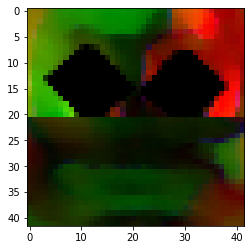

In [13]:
# Example of an optical flow features frame after features concatenation
plt.imshow(dataset[0][0])
plt.show()